In [1]:
# 测试两个不同的资料分布，利用distance matrix的 weight 去做一个 scale，观察是否有效果。

In [2]:
import numpy as np
# 训练网络相关
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
# 绘图相关
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
# 正规化资料
from sklearn import preprocessing

In [90]:
# 绘制直方图
def draw_hist(data=np.random.randn(1000),file='',title='chart',batch_size=64,max=50):
    plt.clf()
    plt.hist(data, range=(0,max),bins=batch_size,normed=0,facecolor="blue", edgecolor="black", alpha=0.7)
    plt.title(title)
    plt.show()

In [22]:
# 绘制 2D scatter plot
def drawscatter(data1,data2,encoder=encoder):
    plt.clf()
    test1 = encoder(data1).cpu().detach().numpy()
    test2 = encoder(data2).cpu().detach().numpy()
    plt.scatter(test1[:,0], test1[:,1], s=75, alpha=.5)
    plt.scatter(test2[:,0], test2[:,1], s=75, alpha=.5)

In [81]:
def distance_mean(data, eps=1e-8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    n = data.shape[0]
    distance_matrix = []
    data = data.to(device)
    for i in range(n):
        dist = data - data[i:i+1].repeat(n, 1)
        dist = dist.pow(2).sum(1)
        dist = (dist+eps).sqrt()
        dist[i] = 0
        distance_matrix.append(dist)
    distance_matrix = torch.cat(distance_matrix,0).view(n,n)
    distance_matrix = distance_matrix.cpu()
    mask = torch.ones(n,n)
    mask = torch.triu(mask,diagonal=1)
    mean = distance_matrix[mask>0].mean()
#     distance_matrix[mask>0] = distance_matrix[mask>0]/mean
    return distance_matrix[mask>0]

In [57]:
# 计算 batch data 两两距离,利用 mse
# 使用 transfer function
def distance_matrix(data,eps=1e-8):
    x1 = data.unsqueeze(1).repeat(1, data.shape[0], 1)
    x2 = data.unsqueeze(0)
    dist = (x1 - x2).pow(2).sum(2)
    dist = (dist+eps).sqrt()
    r = data.shape[0] 
    mask = torch.triu(torch.ones([r,r]),diagonal=1)
    return dist[mask==1]

In [119]:
# 网络结构
def model():
    encoder = nn.Sequential(
        nn.Linear(3, 128),
        nn.LeakyReLU(0.2),
        nn.Linear(128, 64),
        nn.LeakyReLU(0.2),
        nn.Linear(64, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 8),
        nn.LeakyReLU(0.2),
        nn.Linear(8, 2)).to(device)
    decoder = nn.Sequential(
        nn.Linear(2, 8),
        nn.Tanh(),
        nn.Linear(8, 32),
        nn.Tanh(),
        nn.Linear(32, 64),
        nn.Tanh(),
        nn.Linear(64, 128),
        nn.Tanh(),
        nn.Linear(128, 3),
        nn.Sigmoid(),).to(device)
    optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
    loss_func = nn.MSELoss()
    return encoder,decoder,optimizer,loss_func

In [7]:
# 网络参数设定
device = torch.device('cuda')
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

In [83]:
# 宣告两组资料，两组资料分布差距 10 倍
# data1 = np.random.rand(1000,3) 
data1 = torch.randn(1000, 3).cpu().numpy()
data1 = data1 * 3 
data2 = data1 + 20
print(data2[0])

[22.273048 22.498945 18.750593]


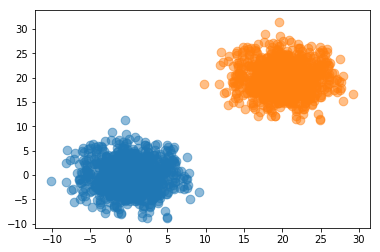

In [84]:
# 2D 散点图绘制
plt.scatter(data1[:,0], data1[:,1], s=75, alpha=.5)
plt.scatter(data2[:,0], data2[:,1], s=75, alpha=.5)
plt.show()

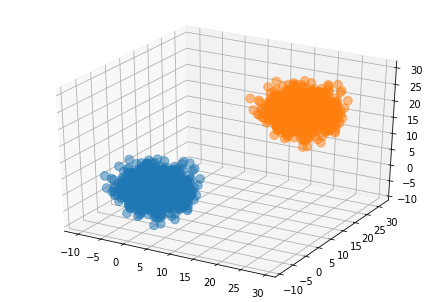

In [85]:
# 3D 三点绘制
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data1[:,0], data1[:,1],data1[:,2], s=75, alpha=.5)
ax.scatter(data2[:,0], data2[:,1],data2[:,2], s=75, alpha=.5)
plt.show()

In [86]:
data1 = torch.Tensor(data1).to(device)
data2 = torch.Tensor(data2).to(device)
data = torch.cat((data1,data2),0)
print(data.shape)

torch.Size([2000, 3])


tensor([[ 2.2730,  2.4989, -1.2494],
        [-2.9506, -6.9979,  0.7829],
        [-1.0701,  2.5795, -2.2192],
        ...,
        [15.9708, 26.0089, 18.9555],
        [22.4924, 19.7791, 22.5895],
        [18.5956, 17.6681, 24.4038]])


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


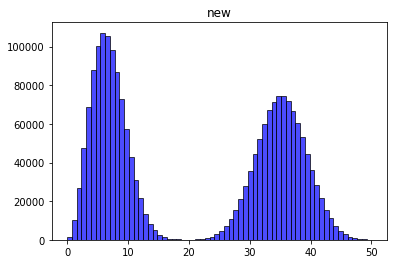

tensor([11.0275,  3.4819,  9.8293,  ...,  9.7236, 10.3025,  4.7888])
tensor([[0.3168, 0.3346, 0.2579],
        [0.1835, 0.1036, 0.3068],
        [0.2315, 0.3365, 0.2346],
        ...,
        [0.6664, 0.9064, 0.7443],
        [0.8328, 0.7549, 0.8318],
        [0.7334, 0.7036, 0.8755]])


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


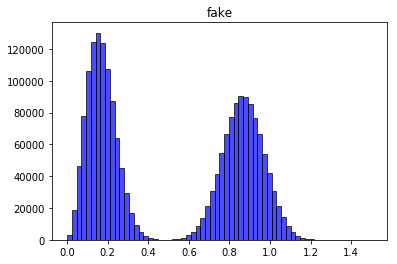

tensor([0.2712, 0.0885, 0.2409,  ..., 0.2415, 0.2507, 0.1201])


In [93]:
# 绘制资料直方图
distance_matix = distance_mean(data=data)
print(data)
draw_hist(data=distance_matix,batch_size=64,title="new",max=50)
print(distance_matix)

data = torch.cat((data1,data2),0).cpu()
normal_data = torch.Tensor(normalizer.transform(data))
print(normal_data)
distance_matix = distance_mean(data=normal_data)
draw_hist(data=distance_matix,batch_size=64,title="fake",max=1.5)
print(distance_matix)

In [12]:
# 对资料进行normalization
normalizer = preprocessing.MinMaxScaler((0,1)).fit(data.cpu())
train_dataset = torch.Tensor(normalizer.transform(data.cpu()))
dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)

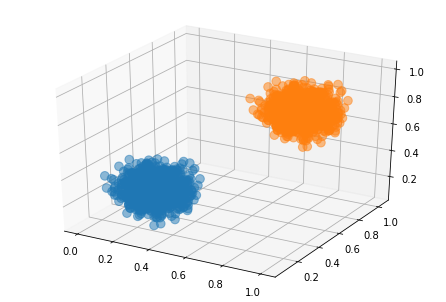

In [92]:
# 3D 三点绘制
fig = plt.figure()
ax = Axes3D(fig)
normal_data1 = normalizer.transform(data1.cpu())
normal_data2 = normalizer.transform(data2.cpu())
ax.scatter(normal_data1[:,0], normal_data1[:,1],normal_data1[:,2], s=75, alpha=.5)
ax.scatter(normal_data2[:,0], normal_data2[:,1],normal_data2[:,2], s=75, alpha=.5)

tensor([ 1.3295, -3.6412, -0.8528])
tensor([0.2927, 0.1852, 0.2675])
tensor([0.3054, 0.2850, 0.2099,  ..., 0.1060, 0.1891, 0.2403])


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


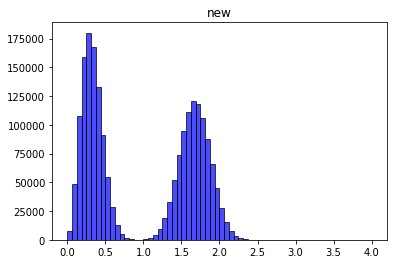

In [55]:
# 绘制资料直方图
data = torch.cat((data1,data2),0).cpu()
print(data[0])
normal_data = torch.Tensor(normalizer.transform(data))
print(normal_data[0])
distance_matix = distance_mean(data=normal_data)
draw_hist(data=distance_matix,batch_size=64,title="new")
print(distance_matix)

In [13]:
encoder,decoder,optimizer,loss_func = model()

In [16]:
# # AE normalizor test
loss = None
for epoch in tqdm_notebook(range(1000)):
    for batch in dataloader:
        optimizer.zero_grad()   # 清空上一步的残余更新参数值
        latent = encoder(batch.to(device))
        predict = decoder(latent)
        loss = loss_func(batch.to(device),predict) # 计算两者的误差
        loss.backward()         # 误差反向传播, 计算参数更新值
        optimizer.step()        # 将参数更新值施加到 net 的 parameters 上
    print(loss)

tensor(0.0671, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0688, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0724, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0683, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0650, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0720, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0614, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0670, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0697, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0666, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0568, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0735, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0633, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0683, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0731, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0605, device='cuda:0',

tensor(0.0565, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0621, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0553, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0528, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0547, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0610, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0616, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0591, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0536, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0689, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0674, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0580, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0607, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0533, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0501, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0705, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0618, device='cuda:0',

tensor(0.0634, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0551, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0644, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0668, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0634, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0629, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0611, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0712, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0589, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0638, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0547, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0588, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0656, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0569, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0635, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0622, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0561, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0658, device='cuda:0',

tensor(0.0602, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0629, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0568, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0585, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0649, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0494, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0581, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0582, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0643, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0646, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0626, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0616, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0713, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0668, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0624, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0555, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0592, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0646, device='cuda:0',

tensor(0.0547, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0633, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0590, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0663, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0626, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0564, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0545, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0717, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0588, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0591, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0646, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0612, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0740, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0583, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0566, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0513, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0674, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0576, device='cuda:0',

tensor(0.0611, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0672, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0568, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0664, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0613, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0601, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0589, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0633, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0688, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0696, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0524, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0511, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0577, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0571, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0586, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0621, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0670, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0680, device='cuda:0',

tensor(0.0602, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0570, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0642, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0588, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0575, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0698, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0595, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0628, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0538, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0643, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0626, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0631, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0573, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0564, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0606, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0678, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0656, device='cuda:0',

0.057673923671245575


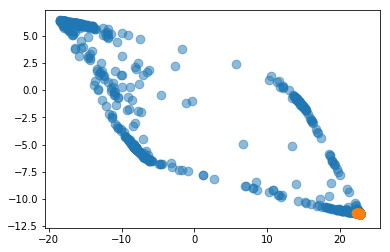

In [17]:
print(loss.item())
drawscatter(data1,data2)

In [96]:
# dist with linear weight
loss = None
encoder_dist_weight,decoder,optimizer,_ = model()
for epoch in tqdm_notebook(range(1000)):
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch.to(device)
        z = encoder_dist_weight(x)
        xd = distance_matrix(data=x)
        zd = distance_matrix(data=z)
        loss = torch.abs(xd-zd)
        xd = 1/(xd+0.5)+0.3
        loss = xd * loss
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    print(loss.item())

0.4591676890850067
0.39949846267700195
0.19085226953029633
0.1273145228624344
0.082085981965065
0.0731523260474205
0.0845235213637352
0.07742765545845032
0.07055258750915527
0.07081173360347748
0.05610043555498123
0.03520732372999191
0.051507167518138885
0.030784226953983307
0.030854003503918648
0.024274218827486038
0.031369373202323914
0.03452581167221069
0.031022848561406136
0.03392395004630089
0.03248559311032295
0.0426110215485096
0.02764689363539219
0.031067127361893654
0.030034098774194717
0.041520047932863235
0.04071075841784477
0.033872090280056
0.03609287366271019
0.04875635728240013
0.023271379992365837
0.04210752993822098
0.04345019906759262
0.045097388327121735
0.02615274302661419
0.03876396268606186
0.042226020246744156
0.033331967890262604
0.04068916290998459
0.04576324298977852
0.029145870357751846
0.03372136875987053
0.03700610622763634
0.02951127104461193
0.026266606524586678
0.022533239796757698
0.034373022615909576
0.029457172378897667
0.02924785017967224
0.030371997

0.03143780305981636
0.03994998335838318
0.03235790133476257
0.02517244592308998
0.025574086233973503
0.02499753050506115
0.03212962672114372
0.02696843631565571
0.018368327990174294
0.017808720469474792
0.0243755504488945
0.014449951238930225
0.018202925100922585
0.02465357817709446
0.02184099517762661
0.02201867289841175
0.0265092421323061
0.0329568050801754
0.029414989054203033
0.03689991682767868
0.024201473221182823
0.03312640264630318
0.022340310737490654
0.0448014959692955
0.03411802649497986
0.03217444568872452
0.02825540117919445
0.02371259406208992
0.03824831545352936
0.022258082404732704
0.018566930666565895
0.03766603767871857
0.02729085460305214
0.043996427208185196
0.045502763241529465
0.02478903718292713
0.049810558557510376
0.0356268472969532
0.03502056002616882
0.019592324271798134
0.03708833083510399
0.03623219579458237
0.059331536293029785
0.024054083973169327
0.02881055884063244
0.024834126234054565
0.02454095333814621
0.024685272946953773
0.035563111305236816
0.0211

0.037450212985277176
0.022394390776753426
0.03608270734548569
0.056856825947761536
0.031079452484846115
0.031214216724038124
0.02708384022116661
0.026308447122573853
0.025927485898137093
0.035045117139816284
0.026714790612459183
0.026241479441523552
0.028880009427666664
0.030858468264341354
0.03287842124700546
0.021990448236465454
0.014572253450751305
0.02301120199263096
0.012592614628374577
0.01962285116314888
0.028099816292524338
0.020197169855237007
0.04680667445063591
0.037143122404813766
0.025148754939436913
0.04527289420366287
0.02532936818897724
0.021723240613937378
0.03193655610084534
0.03733505681157112
0.0404881127178669
0.042709093540906906
0.03432676941156387
0.023991761729121208
0.03178254887461662
0.0160259697586298
0.04952431842684746
0.03365432843565941
0.03366241604089737
0.02487659640610218
0.037391744554042816
0.03874588385224342
0.025848910212516785
0.012607619166374207
0.03775129094719887
0.03480742871761322
0.039836637675762177
0.03460387513041496
0.02397380955517

In [ ]:
# dist with linear weight
loss = None
encoder_dist_weight,decoder,optimizer,_ = model()
for epoch in tqdm_notebook(range(1000)):
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch.to(device)
        z = encoder_dist_weight(x)
        xd = distance_matrix(data=x)
        zd = distance_matrix(data=z)
        loss = torch.abs(xd-zd)
        xd = 1/(xd+0.5)+0.3
        loss = xd * loss
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    print(loss.item())

0.01817234419286251


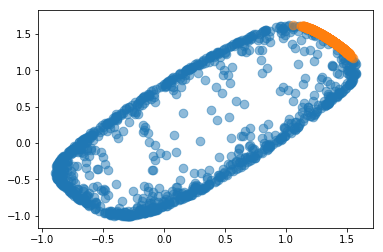

In [97]:
print(loss.item())
drawscatter(data1,data2,encoder_dist_weight)

In [20]:
# # dist 
loss = None
encoder_dist,decoder,optimizer,_ = model()
for epoch in tqdm_notebook(range(1000)):
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch.to(device)
        z = encoder_dist(x)
        xd = distance_matrix(data=x)
        zd = distance_matrix(data=z)
        loss = torch.abs(xd-zd)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    print(loss.item())

0.4085419774055481
0.2900902032852173
0.13765110075473785
0.05736706405878067
0.05609729886054993
0.04941394180059433
0.054467618465423584
0.03578967973589897
0.05865584686398506
0.04201540723443031
0.04250304400920868
0.04732555150985718
0.04616622254252434
0.04083322733640671
0.03921408951282501
0.04011906310915947
0.029726240783929825
0.02691761776804924
0.01860366016626358
0.025275571271777153
0.029508298262953758
0.01873260922729969
0.031537577509880066
0.028491314500570297
0.022122181951999664
0.020563475787639618
0.0187111534178257
0.029054559767246246
0.01865316368639469
0.02109561301767826
0.017977658659219742
0.022368384525179863
0.017970172688364983
0.021341320127248764
0.04212093725800514
0.018336905166506767
0.014958960935473442
0.03521474450826645
0.012334275990724564
0.020111365243792534
0.02049104869365692
0.017102036625146866
0.01728411391377449
0.024632364511489868
0.01550859771668911
0.028182003647089005
0.01927773654460907
0.023383496329188347
0.028127430006861687
0

0.024598492309451103
0.016616469249129295
0.009423745796084404
0.023646758869290352
0.021731749176979065
0.008304855786263943
0.02208074927330017
0.018689708784222603
0.01867046020925045
0.012559832073748112
0.009771124459803104
0.01932607963681221
0.023643314838409424
0.02169600874185562
0.010948038659989834
0.011290227063000202
0.017058325931429863
0.024363970384001732
0.014172292314469814
0.018898753449320793
0.016577089205384254
0.026047831401228905
0.017385952174663544
0.01839032955467701
0.03213021159172058
0.02300477959215641
0.010281050577759743
0.0281510129570961
0.018528476357460022
0.013088192790746689
0.018445774912834167
0.012334778904914856
0.03227589279413223
0.015383374877274036
0.02238844707608223
0.011994489468634129
0.012157663702964783
0.016136273741722107
0.015234909951686859
0.021763846278190613
0.009215257130563259
0.0368574783205986
0.023981833830475807
0.022611690685153008
0.014649352058768272
0.016100583598017693
0.017284203320741653
0.025539938360452652
0.031

0.013179583474993706
0.00945173017680645
0.01995202526450157
0.027209283784031868
0.010307406075298786
0.02552207000553608
0.01303478516638279
0.010037285275757313
0.008915279991924763
0.019997483119368553
0.01815553568303585
0.021072909235954285
0.029830753803253174
0.015365361236035824
0.013098006136715412
0.008070375770330429
0.018607983365654945
0.016162775456905365
0.022571584209799767
0.023333758115768433
0.01480609830468893
0.02550765685737133
0.009436216205358505
0.017272597178816795
0.015473446808755398
0.025359051302075386
0.01543725747615099
0.028199290856719017
0.02967653051018715
0.016101347282528877
0.02259131334722042
0.012845957651734352
0.010732498951256275
0.026848359033465385
0.02576923556625843
0.013635744340717793
0.02075122855603695
0.02239971049129963
0.014424736611545086
0.012523489072918892
0.021817931905388832
0.01862192340195179
0.016118790954351425
0.01692824251949787
0.018458645790815353
0.026495058089494705
0.014308137819170952
0.016842501237988472
0.01859

0.021008694544434547


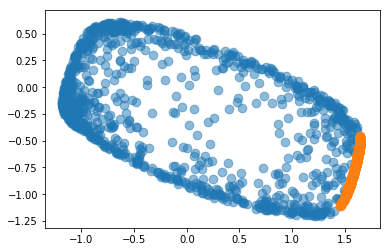

In [25]:
print(loss.item())
drawscatter(data1,data2,encoder_dist)

In [28]:
dataloader_no_normal = torch.utils.data.DataLoader(data.cpu(),batch_size=BATCH_SIZE,shuffle=True,num_workers=1)

In [62]:
# # AE normalizor test
loss = None
encoder_nn,decoder,optimizer,_ = model()
for epoch in tqdm_notebook(range(1000)):
    for batch in dataloader_no_normal:
        optimizer.zero_grad()   # 清空上一步的残余更新参数值
        latent = encoder_nn(batch.to(device))
        predict = decoder(latent)
        loss = loss_func(batch.to(device),predict) # 计算两者的误差
        loss.backward()         # 误差反向传播, 计算参数更新值
        optimizer.step()        # 将参数更新值施加到 net 的 parameters 上
    print(loss)

tensor(264.0878, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(202.6515, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(251.1975, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(128.3430, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(171.7871, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(154.9430, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(161.2037, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(134.8183, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(89.4368, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(240.3621, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(250.4200, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(241.8187, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(190.2637, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(111.2969, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(236.5379, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(316.3941, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(225.6827, device='cuda:0', grad_fn=<MeanBackward1>

tensor(119.2439, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(159.5108, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(279.9515, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(233.3152, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(230.4247, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(124.8134, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(174.2252, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(177.8097, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(192.1014, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(254.8452, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(197.2068, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(214.6821, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(276.4631, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(157.5237, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(183.5447, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(231.8982, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(265.4225, device='cuda:0', grad_fn=<MeanBackward1

tensor(271.8375, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(222.0465, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(223.2192, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(96.9116, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(149.7592, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(255.7641, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(134.3096, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(175.3725, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(273.2922, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(147.8087, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(200.3323, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(186.8688, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(91.4590, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(177.5964, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(208.9060, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(178.2046, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(149.9799, device='cuda:0', grad_fn=<MeanBackward1>)

tensor(202.7289, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(233.4956, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(220.7262, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(171.7005, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(136.7136, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(218.3619, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(288.8455, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(131.5729, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(190.0571, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(180.5514, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(259.3727, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(225.1362, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(236.7411, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(184.1640, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(182.2915, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(127.0700, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(198.3750, device='cuda:0', grad_fn=<MeanBackward1

tensor(221.3805, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(161.7311, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(190.1711, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(225.2820, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(269.1518, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(178.1006, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(174.4944, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(211.3278, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(219.8901, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(254.1014, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(182.9987, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(249.0102, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(157.5401, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(214.3488, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(128.0948, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(116.5737, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(149.2293, device='cuda:0', grad_fn=<MeanBackward1

tensor(170.7585, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(249.8936, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(215.2742, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(153.4342, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(165.9140, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(128.6295, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(182.3315, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(199.5835, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(257.4742, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(238.5365, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(189.4503, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(71.6572, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(137.4373, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(173.6181, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(193.2892, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(169.1055, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(176.3033, device='cuda:0', grad_fn=<MeanBackward1>

tensor(194.6904, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(267.6942, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(224.8526, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(271.3515, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(189.3853, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(170.3131, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(245.6228, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(259.5123, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(187.5536, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(243.3393, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(149.0033, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(186.0497, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(261.2857, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(165.4028, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(146.5984, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(186.8285, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(113.8591, device='cuda:0', grad_fn=<MeanBackward1

tensor(263.5636, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(214.5758, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(158.8242, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(148.0296, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(183.9789, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(240.0370, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(134.8489, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(131.2923, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(229.0089, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(144.0293, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(195.9959, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(191.0362, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(128.9211, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(176.1145, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(155.7289, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(295.2181, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(303.4718, device='cuda:0', grad_fn=<MeanBackward1

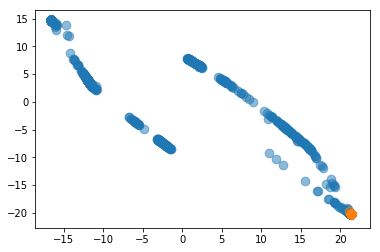

In [63]:
drawscatter(data1,data2,encoder_nn)

In [30]:
# # dist no normalization
loss = None
encoder_dist_no_normal,decoder,optimizer,_ = model()
for epoch in tqdm_notebook(range(1000)):
    for batch in dataloader_no_normal:
        optimizer.zero_grad()
        x = batch.to(device)
        z = encoder_dist_no_normal(x)
        xd = distance_matrix(data=x)
        zd = distance_matrix(data=z)
        loss = torch.abs(xd-zd)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    print(loss.item())

20.620166778564453
20.02948570251465
20.836929321289062
18.33148765563965
20.01361656188965
20.766969680786133
20.095869064331055
20.66221046447754
19.369792938232422
20.611160278320312
19.922733306884766
19.378549575805664
18.707435607910156
19.121423721313477
18.454998016357422
16.45763397216797
18.912578582763672
19.937679290771484
19.047840118408203
17.663185119628906
17.953533172607422
18.48196792602539
19.894359588623047
18.428312301635742
16.59169578552246
17.873319625854492
17.10784149169922
18.642749786376953
18.184852600097656
19.685258865356445
17.85744285583496
18.18244171142578
18.24062156677246
17.2023983001709
17.93938446044922
16.072059631347656
12.736530303955078
17.462814331054688
15.682377815246582
17.51871109008789
18.809816360473633
17.951677322387695
17.125328063964844
18.82440948486328
17.37310028076172
19.38920783996582
17.09369468688965
16.102371215820312
17.33719253540039
16.903291702270508
18.7056827545166
16.42853546142578
16.752952575683594
16.1550540924072

4.640488147735596
5.138297080993652
4.152042865753174
3.6658642292022705
3.5493288040161133
3.3738083839416504
3.824965715408325
3.990601062774658
4.495805740356445
3.4748523235321045
4.092321395874023
3.678997278213501
3.2922141551971436
3.9660112857818604
3.813479423522949
3.8215553760528564
3.0566251277923584
4.007128715515137
2.9766674041748047
2.2488298416137695
2.537454843521118
4.420647621154785
3.520693302154541
3.884536027908325
2.977146625518799
2.679457902908325
3.4900851249694824
3.9848976135253906
3.4881558418273926
3.2670202255249023
2.913592576980591
2.883481025695801
2.462242364883423
2.9960079193115234
3.387519598007202
2.7331199645996094
2.778759717941284
2.6037299633026123
2.415274143218994
3.7469613552093506
2.200538158416748
3.746870517730713
2.6248388290405273
2.3458187580108643
3.0715842247009277
3.3142383098602295
3.39504075050354
3.3996760845184326
4.443979263305664
2.887852191925049
2.1989986896514893
2.6977250576019287
2.811469078063965
3.0972847938537598
3.0

1.7878391742706299
1.796790361404419
1.7071346044540405
2.6300315856933594
1.7621445655822754
1.0534532070159912
1.45936918258667
1.9497628211975098
1.8472920656204224
2.2272791862487793
2.129286289215088
2.2603836059570312
1.4538483619689941
1.3400449752807617
1.500296950340271
1.8332875967025757
1.8168703317642212
2.0970468521118164
2.153069257736206
1.6065669059753418
2.0982277393341064
1.6011204719543457
1.5699061155319214
1.8670982122421265
1.472471833229065
1.9846497774124146
1.8897954225540161
2.1494340896606445
1.41254460811615
1.9490008354187012
1.773249626159668
1.428963303565979
1.1710292100906372
0.9780437350273132
1.0808637142181396
1.5227019786834717
1.615010380744934
2.1101109981536865
1.3846410512924194
2.0076255798339844
1.6853740215301514
1.7830432653427124
1.371364712715149
1.7127981185913086
1.618295431137085
2.138531446456909
1.7911704778671265
1.7707924842834473
1.6580085754394531
1.8822370767593384
1.3140159845352173
1.804133415222168
2.1014864444732666
1.6697645

0.23900125920772552


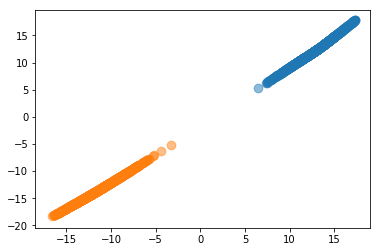

In [32]:
print(loss.item())
drawscatter(data1,data2,encoder_dist_no_normal)

7.331531047821045
6.804603099822998
5.450974464416504
3.7262566089630127
0.8297168016433716
1.2906473875045776
0.9850528836250305
1.1039061546325684
1.0155143737792969
0.7682827115058899
0.7705963253974915
1.1165817975997925
0.6656811237335205
0.7636308670043945
1.0083059072494507
0.7572360038757324
0.6465774774551392
0.7547767758369446
0.6878993511199951
0.5589184761047363
0.7632438540458679
0.6022226810455322
0.8413009643554688
0.5531890988349915
0.8111448287963867
0.6625691056251526
0.846308171749115
0.5138024091720581
0.5426514744758606
0.46749147772789
0.7007721662521362
0.7424895167350769
0.7020193934440613
0.6142279505729675
0.6900317072868347
0.773813009262085
0.5753291249275208
0.7862322926521301
0.6760039329528809
0.4981009364128113
0.4264528453350067
0.2981313169002533
0.4357292056083679
0.4625985622406006
0.4883348345756531
0.3803474009037018
0.5106785297393799
0.25690922141075134
0.49847808480262756
0.34527644515037537
0.3718906044960022
0.45219820737838745
0.3864286839962

0.24173368513584137
0.2840583920478821
0.23215259611606598
0.25326722860336304
0.27686938643455505
0.3173205852508545
0.25566768646240234
0.3073223829269409
0.3509482145309448
0.25751906633377075
0.20674608647823334
0.35805389285087585
0.37896978855133057
0.22618643939495087
0.29699626564979553
0.3347529470920563
0.1479247361421585
0.29667428135871887
0.42673468589782715
0.19108951091766357
0.15463219583034515
0.40947893261909485
0.22127893567085266
0.16122695803642273
0.26002374291419983
0.3247852325439453
0.23080435395240784
0.2830146551132202
0.3012906014919281
0.1356937438249588
0.4119095504283905
0.32928112149238586
0.2532185912132263
0.21114659309387207
0.4226550757884979
0.3577663004398346
0.3233310282230377
0.30484873056411743
0.5367054343223572
0.18074265122413635
0.38444629311561584
0.2583659291267395
0.10105834901332855
0.35955241322517395
0.2867761254310608
0.38625985383987427
0.36885425448417664
0.24839267134666443
0.30331283807754517
0.44556742906570435
0.2968799769878387

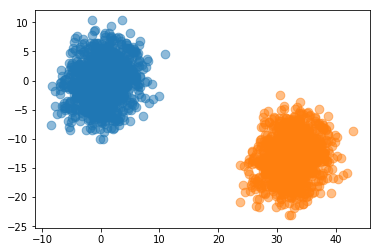

In [121]:
# dist with linear weight no normalization
loss = None
encoder_dist_weight_nn,decoder,optimizer,_ = model()
for epoch in tqdm_notebook(range(1000)):
    for batch in dataloader_no_normal:
        optimizer.zero_grad()
        x = batch.to(device)
        z = encoder_dist_weight_nn(x)
        xd = distance_matrix(data=x)
        zd = distance_matrix(data=z)
        loss = torch.abs(xd-zd)
        xd = 1/(xd+0.1)+0.3
        loss = xd * loss
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    test1 = encoder_dist_weight_nn(data1).cpu().detach().numpy()
    test2 = encoder_dist_weight_nn(data2).cpu().detach().numpy()
    plt.clf()
    plt.scatter(test1[:,0], test1[:,1], s=75, alpha=.5)
    plt.scatter(test2[:,0], test2[:,1], s=75, alpha=.5)
    plt.savefig('./randomdata_test/dist_with_weight/leakyrelu/1(xd+0.1)+0.3/'+str(epoch)+'.png')
    print(loss.item())

0.23900125920772552


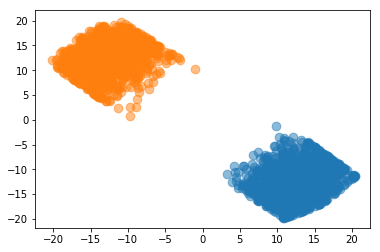

In [33]:
print(loss.item())
drawscatter(data1,data2,encoder_dist_weight_nn)

7.256271839141846
6.698851585388184
6.526203155517578
5.079361438751221
4.736375331878662
2.6953787803649902
1.1553716659545898
0.7737269997596741
0.6477066874504089
0.6755882501602173
0.601938009262085
0.6079497337341309
0.6772125363349915
0.7725187540054321
0.7945194840431213
0.6759392023086548
0.7071921229362488
0.7826569080352783
0.7904047966003418
0.7709162831306458
0.6806049346923828
0.6659956574440002
0.9699438214302063
0.7573473453521729
0.7391991019248962
0.6117452383041382
0.6900651454925537
0.6861363053321838
1.1396763324737549
0.7615711092948914
0.8172270655632019
0.6521671414375305
0.8353467583656311
0.5586866736412048
1.0166782140731812
0.7554998993873596
0.8995376229286194
0.8356354236602783
1.0133941173553467
0.7613420486450195
0.6235917806625366
0.8135011196136475
0.8993421196937561
0.5438041090965271
0.7767271399497986
0.7879695296287537
0.6841503381729126
0.486661821603775
0.9903109073638916
0.5297202467918396
0.5629687905311584
0.7513276934623718
0.9646251201629639


0.33972638845443726
0.34732457995414734
0.33668819069862366
0.24707695841789246
0.1493867039680481
0.24311195313930511
0.19685937464237213
0.25792381167411804
0.326892614364624
0.19782255589962006
0.24681732058525085
0.24516838788986206
0.2638534605503082
0.17087680101394653
0.29885801672935486
0.5134118795394897
0.2728613018989563
0.25053033232688904
0.332755982875824
0.3611592650413513
0.42986321449279785
0.21351970732212067
0.2850624918937683
0.24303215742111206
0.23043210804462433
0.29879438877105713
0.29312917590141296
0.4158672094345093
0.22397296130657196
0.3106405436992645
0.21823963522911072
0.2560047209262848
0.4188638925552368
0.2587553560733795
0.2703061103820801
0.33230504393577576
0.12392108887434006
0.3137272596359253
0.29488247632980347
0.1942828893661499
0.2399919182062149
0.3666263818740845
0.2535230815410614
0.18772585690021515
0.3771984279155731
0.34206289052963257
0.32938864827156067
0.3377731442451477
0.3856203854084015
0.22634314000606537
0.22024491429328918
0.26

0.2509908080101013
0.31927821040153503
0.1840779036283493
0.31029877066612244
0.19010530412197113
0.3037046790122986
0.39337795972824097
0.3254047632217407
0.259198933839798
0.20262537896633148
0.27579838037490845
0.25637537240982056
0.29790422320365906
0.23654362559318542
0.3377963602542877
0.30818483233451843
0.361151784658432
0.28570815920829773
0.2076943963766098
0.33650100231170654
0.20384642481803894
0.2675504684448242
0.24022963643074036
0.187614306807518
0.2779041528701782
0.18557287752628326
0.15305498242378235
0.334950715303421
0.222931906580925
0.2709707021713257
0.17458894848823547
0.237738236784935
0.23380614817142487
0.25345587730407715
0.26133081316947937
0.20754840970039368
0.14471982419490814
0.3932444155216217
0.22620292007923126
0.3381103575229645
0.4075407385826111
0.41897380352020264
0.281711220741272
0.22453340888023376
0.28472211956977844
0.28339657187461853
0.24601060152053833
0.38599494099617004
0.34477585554122925
0.23930920660495758
0.1611146777868271
0.38393

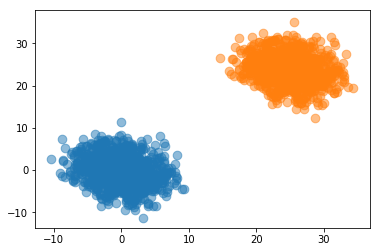

In [120]:
# dist with linear weight no normalization
loss = None
encoder_dist_weight_nn,decoder,optimizer,_ = model()
test1 = encoder(data1).cpu().detach().numpy()
test2 = encoder(data2).cpu().detach().numpy()
for epoch in tqdm_notebook(range(1000)):
    i = 0 
    for batch in dataloader_no_normal:
        optimizer.zero_grad()
        x = batch.to(device)
        z = encoder_dist_weight_nn(x)
        xd = distance_matrix(data=x)
        zd = distance_matrix(data=z)
        loss = torch.abs(xd-zd)
        xd = 1/(xd+0.5)+0.3
        loss = xd * loss
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    test1 = encoder_dist_weight_nn(data1).cpu().detach().numpy()
    test2 = encoder_dist_weight_nn(data2).cpu().detach().numpy()
    plt.clf()
    plt.scatter(test1[:,0], test1[:,1], s=75, alpha=.5)
    plt.scatter(test2[:,0], test2[:,1], s=75, alpha=.5)
    plt.savefig('./randomdata_test/dist_with_weight/leakyrelu/1(x+0.5)+0.3/'+str(epoch)+'.png')
    print(loss.item())

13.823654174804688
15.592144966125488
12.122400283813477
7.4344892501831055
2.364039421081543
1.8879258632659912
2.343954086303711
1.7060800790786743
1.8352786302566528
1.6826287508010864
2.555262804031372
1.8961955308914185
1.501244306564331
1.1156967878341675
1.2105883359909058
1.2496377229690552
1.2027586698532104
1.8079588413238525
1.1823513507843018
1.638649821281433
1.3038694858551025
1.6495343446731567
1.4225422143936157
1.6663615703582764
1.460229516029358
1.1164770126342773
1.513824462890625
1.1586871147155762
0.8575728535652161
1.561258316040039
1.268654704093933
1.159279227256775
1.664138674736023
1.8439359664916992
1.69918692111969
2.0060439109802246
1.0733963251113892
1.4492470026016235
1.626380443572998
1.5459009408950806
1.4013090133666992
1.2517218589782715
1.3615057468414307
1.1318576335906982
1.7806850671768188
1.5681486129760742
1.928376317024231
0.7997829914093018
1.1822574138641357
1.504417061805725
1.5113078355789185
1.425790786743164
2.0940194129943848
1.42107498

0.8342005014419556
0.7282927632331848
0.3107980489730835
0.560357391834259
0.47071602940559387
0.6877431869506836
0.6072516441345215
0.7183626890182495
0.44443508982658386
0.7340899705886841
0.5607098937034607
0.242876797914505
0.48525455594062805
0.4366666078567505
0.5529485940933228
0.5038594007492065
0.9839316010475159
0.3994932472705841
0.4943307936191559
0.6119840145111084
1.087887167930603
0.40543586015701294
0.2974141538143158
0.6058686971664429
0.2763126492500305
0.5800483822822571
0.43427178263664246
0.46206921339035034
0.4782268702983856
0.6001748442649841
0.6766699552536011
0.3025459945201874
0.4787921607494354
0.7522865533828735
0.8884673714637756
0.6739820241928101
0.37103745341300964
0.6860203146934509
0.4067504107952118
0.5910419821739197
0.4904094338417053
0.29959872364997864
0.5200713872909546
0.7487163543701172
0.6067079901695251
0.6525246500968933
0.6251760125160217
0.7311683893203735
0.8752461671829224
0.46773695945739746
0.3037674129009247
0.4255894422531128
0.4845

0.5040342807769775
0.31460002064704895
0.503309428691864
0.7941634058952332
0.4213314950466156
0.5140783786773682
0.3962143063545227
0.8661102652549744
0.3733542561531067
0.5017682909965515
0.5502116084098816
0.8327878713607788
0.5264361500740051
0.5746099948883057
0.8458628058433533
0.9350606799125671
0.5725581049919128
0.44270679354667664
0.5904176831245422
0.32226982712745667
0.5665115714073181
0.6041679978370667
0.668712317943573
0.43379634618759155
0.48513802886009216
0.693845808506012
0.5592509508132935
0.3942511975765228
0.23518776893615723
0.6593645811080933
0.894874632358551
0.5208886861801147
0.6795051693916321
0.5608580708503723
0.7046570181846619
1.053539752960205
0.5718343257904053
0.6197989583015442
0.7007482051849365
0.7823820114135742
0.5514558553695679
0.5120774507522583
0.6297135949134827
1.1454994678497314
0.7392895221710205
0.47373032569885254
0.5193947553634644
0.4185374677181244
0.2895122170448303
0.49301135540008545
0.6181033253669739
0.7027435898780823
0.4376267

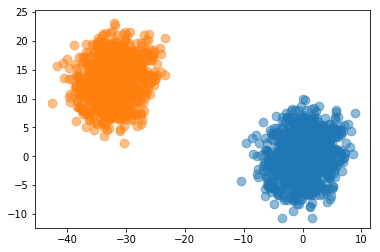

In [122]:
# dist with linear weight no normalization
loss = None
encoder_dist_weight_nn,decoder,optimizer,_ = model()
for epoch in tqdm_notebook(range(1000)):
    for batch in dataloader_no_normal:
        optimizer.zero_grad()
        x = batch.to(device)
        z = encoder_dist_weight_nn(x)
        xd = distance_matrix(data=x)
        zd = distance_matrix(data=z)
        loss = torch.abs(xd-zd)
        xd = 1/(5*xd+1)+0.8
        loss = xd * loss
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    test1 = encoder_dist_weight_nn(data1).cpu().detach().numpy()
    test2 = encoder_dist_weight_nn(data2).cpu().detach().numpy()
    plt.clf()
    plt.scatter(test1[:,0], test1[:,1], s=75, alpha=.5)
    plt.scatter(test2[:,0], test2[:,1], s=75, alpha=.5)
    plt.savefig('./randomdata_test/dist_with_weight/leakyrelu/1(5x+1)+0.8/'+str(epoch)+'.png')
    print(loss.item())

17.364694595336914
17.109375
13.512070655822754
7.576491355895996
2.86708664894104
3.224116086959839
2.0879688262939453
2.330495834350586
1.754030466079712
1.9979586601257324
1.35254967212677
1.7001150846481323
1.4705994129180908
1.7044119834899902
1.692653775215149
1.4968990087509155
3.888011932373047
1.635743260383606
2.763011932373047
1.5110774040222168
1.6012089252471924
1.7137517929077148
1.8197256326675415
1.6222716569900513
2.017116069793701
1.8453655242919922
1.5301333665847778
1.808397889137268
2.55429744720459
1.1874303817749023
1.3240638971328735
2.1362075805664062
1.5993691682815552
2.0190370082855225
2.48500919342041
2.186289072036743
1.6203749179840088
1.4883105754852295
1.338602066040039
1.5556879043579102
1.087524175643921
1.302719235420227
1.5288175344467163
1.9274429082870483
1.344141960144043
2.6399059295654297
1.9016330242156982
1.3583168983459473
1.6404229402542114
1.6583614349365234
0.9917524456977844
1.5888198614120483
1.6298198699951172
1.7235838174819946
2.0949

0.6595411896705627
0.8018543720245361
0.6154533624649048
0.5962255001068115
0.6714407205581665
0.48813360929489136
0.8943002820014954
0.47667714953422546
0.7413535118103027
0.3199673593044281
0.5634441375732422
0.7528850436210632
0.6347853541374207
0.4020833671092987
0.4882267117500305
0.5146694779396057
0.42989274859428406
0.4473673403263092
0.6281676292419434
0.387877494096756
0.933195948600769
0.5539735555648804
1.189374327659607
1.0206862688064575
0.8432506918907166
0.8442484736442566
0.40822070837020874
0.7106362581253052
0.6171116232872009
0.59321528673172
0.8684289455413818
0.9714851975440979
0.3994464576244354
0.49980655312538147
0.8883612751960754
0.807778537273407
0.8279497027397156
0.5381997227668762
1.0191442966461182
0.7908376455307007
0.6285308003425598
0.650138258934021
0.493728369474411
0.5900673270225525
0.7273247241973877
0.8072590827941895
0.8234572410583496
0.603391170501709
0.7144943475723267
0.7172659039497375
0.8519234657287598
0.6297792196273804
0.56077724695205

0.653066873550415
1.0116080045700073
0.7511511445045471
1.065814733505249
0.4570569694042206
0.44624999165534973
0.3707570731639862
0.30566567182540894
0.5529487729072571
0.6774822473526001
0.7240384817123413
0.4500722587108612
0.3209453225135803
0.6936601400375366
0.881636917591095
0.55389404296875
0.3979521095752716
0.8522061109542847
0.8499569296836853
1.150152564048767
0.40928709506988525
0.42787593603134155
0.9029580950737
0.6831533908843994
0.7179765701293945
0.9963591694831848
0.7079068422317505
0.9297136068344116
0.4808652997016907
1.1231039762496948
0.7577486038208008
0.5129168033599854
0.4878935217857361
0.5635770559310913
0.8460549116134644
0.5349161624908447
0.7956050038337708
0.6855000257492065
0.6260943412780762
0.6998209953308105
0.6728757619857788
0.6430359482765198
0.6789259910583496
0.661508321762085
0.6449374556541443
0.6383191347122192
0.9037984609603882
0.5820226073265076
0.9740633964538574
0.7534965872764587
0.8429672718048096
0.4508087933063507
0.4473526775836944

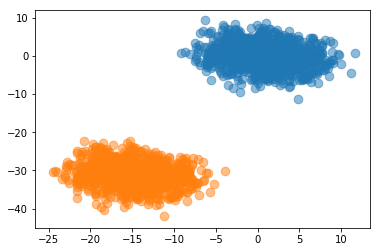

In [123]:
# dist no normalization
loss = None
encoder_dist_weight_nn,decoder,optimizer,_ = model()
for epoch in tqdm_notebook(range(1000)):
    for batch in dataloader_no_normal:
        optimizer.zero_grad()
        x = batch.to(device)
        z = encoder_dist_weight_nn(x)
        xd = distance_matrix(data=x)
        zd = distance_matrix(data=z)
        loss = torch.abs(xd-zd)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    test1 = encoder_dist_weight_nn(data1).cpu().detach().numpy()
    test2 = encoder_dist_weight_nn(data2).cpu().detach().numpy()
    plt.clf()
    plt.scatter(test1[:,0], test1[:,1], s=75, alpha=.5)
    plt.scatter(test2[:,0], test2[:,1], s=75, alpha=.5)
    plt.savefig('./randomdata_test/dist_with_weight/leakyrelu/noweight/'+str(epoch)+'.png')
    print(loss.item())